In [ ]:
# 3/20 check point 구현 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==1.15
!pip install keras==2.2.4
!pip install keras_tqdm

In [ ]:
#!pip install tensorflow==1.15.0
import tensorflow as tf
import keras
print(tf.__version__) # 1,15,0
print(keras.__version__) # 2.2.4

1.15.0
2.2.4


Using TensorFlow backend.


In [ ]:
! pip install -U segmentation-models

In [ ]:
import segmentation_models as sm
keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf

# Set some parameters # 3/23 : 256,512 -> (690,1600)(X) , (688,1600)(O), (512,1024)
IMG_WIDTH = 512
IMG_HEIGHT = 1024
IMG_CHANNELS = 3

# 파일 경로 설정
npy_path = '/content/drive/My Drive/Colab Notebooks/webtoon_data/npy_data/1024_512/'

x_train_load = np.load(npy_path+'x_train.npy')
y_train_load = np.load(npy_path+'y_train.npy')

x_val_load = np.load(npy_path+'x_val.npy')
y_val_load = np.load(npy_path+'y_val.npy')


TEST_PATH = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/test_images/'
TEST_PATH_IMG=TEST_PATH # 예측할 데이터 파일

test_ids_img = next(os.walk(TEST_PATH_IMG))[2] 
test_ids_img.sort()

In [ ]:
model = sm.Unet('resnet34', classes=1, activation='sigmoid',input_shape=(None, None, 3))

In [ ]:
'''
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optimizer=Adam(lr=1e-5),loss=total_loss,
    metrics=metrics)
''' 
model.compile(optimizer=Adam(lr=1e-5),loss=sm.losses.bce_jaccard_loss,
  metrics=[sm.metrics.iou_score],)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


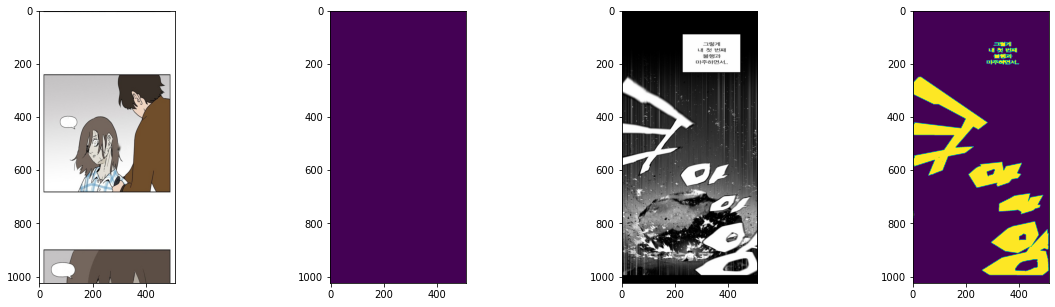

In [ ]:
import matplotlib.pyplot as plt

ix = random.randint(0, len(x_val_load))
tx = random.randint(0, len(y_val_load))

_,axes = plt.subplots(1,4, figsize=(20,5))

axes[0].imshow(x_train_load[ix])
axes[1].imshow(np.squeeze(y_train_load[ix]))
axes[2].imshow(x_val_load[tx])
axes[3].imshow(np.squeeze(y_val_load[tx]))
plt.show()


In [ ]:
y_train_load.shape

(836, 1024, 512, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = dict(
        featurewise_center = True,
        featurewise_std_normalization=True,
        rotation_range=30, #이미지 회전 범위 (degrees)
        width_shift_range=0.2, #그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
        height_shift_range=0.2,
        rescale=1./255, #flow 로 변형된 이미지 확인할때 주석처리
        zoom_range=0.1
        )

image_datagen = ImageDataGenerator(datagen)
mask_datagen = ImageDataGenerator(datagen)
validation_image_datagen = ImageDataGenerator(ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rescale= 1./255))
validation_mask_datagen = ImageDataGenerator(rescale= 1./255)

seed = 1
seed2 = 2

image_datagen.fit(x_train_load, augment=True, seed=seed)
mask_datagen.fit(y_train_load, augment=True, seed=seed)
#validation_image_datagen.fit(x_val_load,augment=True, seed = seed2)
#validation_mask_datagen.fit(y_val_load,augment=True, seed = seed2)


In [ ]:
TRAIN_PATH_IMG = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/train_images/'
TRAIN_PATH_MASK = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/train_masks/'
VAL_PATH_IMG = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/val_images/'
VAL_PATH_MASK = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/val_masks/'

size = (1024,512)
batch_sizes = 4
image_generator = image_datagen.flow_from_directory(
    TRAIN_PATH_IMG,
    target_size = size,
    color_mode='rgb',
     class_mode=None,
     batch_size = batch_sizes,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    TRAIN_PATH_MASK,
    target_size = size,
    color_mode='grayscale',
     class_mode=None,
     batch_size = batch_sizes,
    seed=seed)

validation_image_generator = validation_image_datagen.flow_from_directory(
		VAL_PATH_IMG,
		target_size= size,
		color_mode='rgb',
        class_mode=None,
        batch_size = batch_sizes,
        seed=seed)
		

validation_mask_generator = validation_mask_datagen.flow_from_directory(
		VAL_PATH_MASK,
		target_size= size,
		color_mode='grayscale',
        class_mode=None,
        batch_size = batch_sizes,
        seed=seed)
		
#train_generator = zip(image_generator, mask_generator)
#validation_generator = zip(validation_image_generator,validation_mask_generator)

Found 836 images belonging to 1 classes.
Found 836 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.


In [ ]:
def combine_generator(gen1, gen2):
    while True:
        yield(gen1.next(), gen2.next())   
train_generator = combine_generator(image_generator, mask_generator)
val_generator = combine_generator(validation_image_generator, validation_mask_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


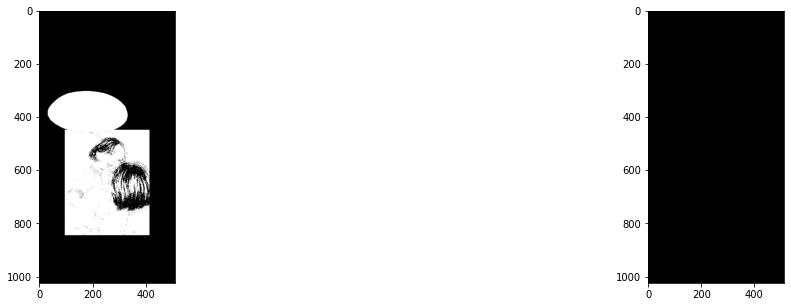

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


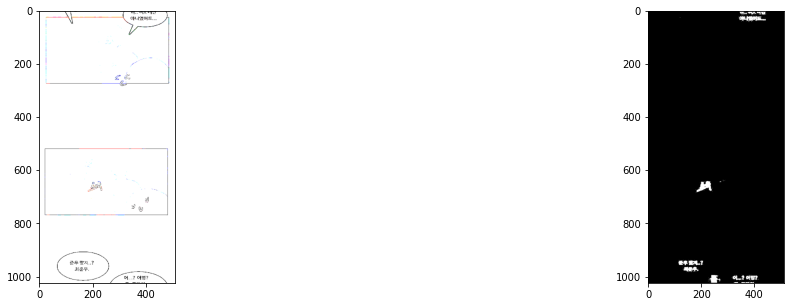

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


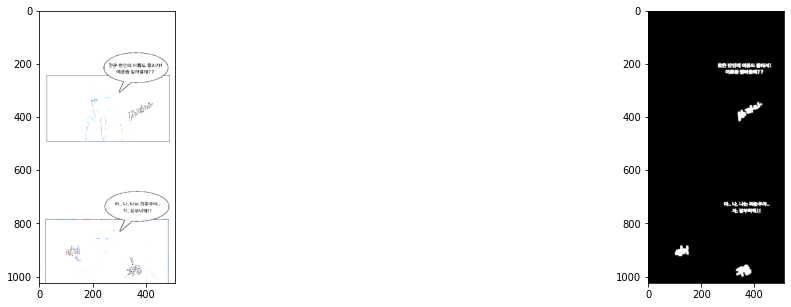

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


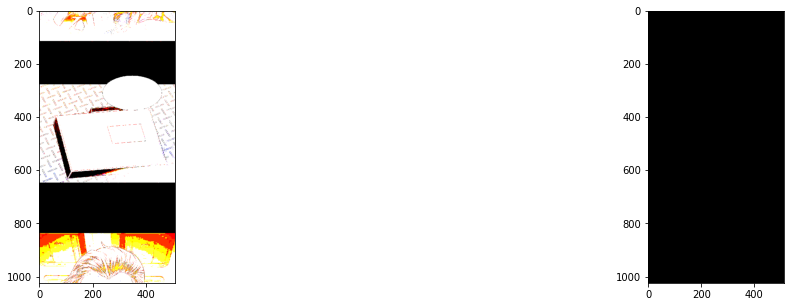

In [ ]:
# Pick out an example
import cv2
test_data = next(train_generator)
(ori, mask) = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].imshow(cv2.cvtColor(ori[i,:,:,:], cv2.COLOR_BGR2RGB))
    axes[1].imshow(cv2.cvtColor(mask[i,:,:,:], cv2.COLOR_BGR2RGB) * 1.)
    plt.show()

In [ ]:
drive_path = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/'
MODEL_SAVE_FOLDER_PATH = drive_path+'model_checkPoint_test_0502/1024_512_smUnet/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
model_path = MODEL_SAVE_FOLDER_PATH+'{epoch:02d}-{val_loss:.4f}.h5'


In [ ]:
# Fit model
# monitor='loss'
checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_loss', 
                               save_best_only=True, save_weights_only= True)

In [ ]:

#model.load_weights('/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/model_checkPoint/10--97.4605.h5') #<- 예측할때 주석풀고 실행
model.fit_generator(
    train_generator,
    steps_per_epoch=1000, # sample_수 836/ batch_size : 4
    epochs=10,
    verbose=1,
    validation_data=val_generator,
    validation_steps=50, # sample_수 25/ batch_size : 5 
    callbacks=[checkpointer])

In [ ]:
# Get and resize test images
X_test = np.zeros((len(test_ids_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for  n in tqdm(range(len(test_ids_img)), total=len(test_ids_img)):
    path_img = TEST_PATH_IMG
    
    img_id_=test_ids_img[n]
   
    
    img = imread(path_img + img_id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 16/16 [00:02<00:00,  6.78it/s]

Done!


In [ ]:
# 다시 훈련 시킬때 실행 weight파일 이름 넣어야함 
model.load_weights(drive_path+'model_checkPoint/35-0.0782.h5') #loss 
# 에포크 124 + 124

In [ ]:
# Predict on train, val and test
path = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/'
model.load_weights(path +'model_checkPoint_test_0502/1024_512_smUnet/01-1.9291.h5') #<- 예측할때 주석풀고 실행
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test1 = model.predict(X_test, verbose=1)

# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))


16/16 [==============================] - 1s 79ms/step


In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
np.squeeze(preds_test[ix]).shape

(512, 256)

In [ ]:
# Perform a sanity check on some random validation samples
#ix = random.randint(0, len(preds_test_t))
ix = random.randint(0, len(X_test))

imshow(np.squeeze(preds_test1[ix]*255))
plt.show()
imshow((X_test[ix]))
plt.show()

#imshow(np.squeeze(preds_test_t[ix]*255))
#imshow(np.squeeze(preds_test_upsampled[ix]))

#plt.show()



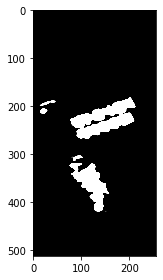

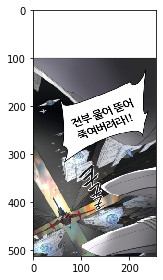

In [ ]:
imshow(np.squeeze(preds_test[0]))
plt.show()
imshow((X_test[0]))
plt.show()

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


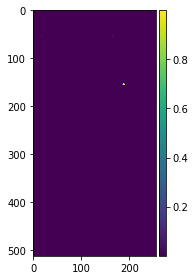

In [ ]:
imshow(np.squeeze(preds_test[ix]))
plt.show()

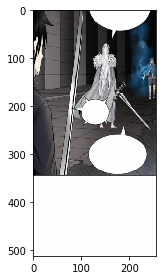

In [ ]:
imshow((X_test[ix]))
plt.show()

In [ ]:
# 모델 돌려보기 사진 저장 경로 설정 필요
import cv2  # *255는 위에 mask범위를 보면 0~1인데 마스킹된 부분이 1 -> 노랑으로 되있어서 255를 곱해준다.
cv2.imwrite(drive_path+'predict_images/epoch548v1_predict.jpg',(preds_test_upsampled[ix]))

True

In [ ]:
len(preds_test_t)

6